<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Time-Series-Analysis-of-Microsoft-Dataset/blob/main/Time_Series_analysis_of_Microsoft_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'microsoft-stock-time-series-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1409311%2F2334627%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T171011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b0c0f2006a4012776b35f4b70f1914dac7d34871577a02946a2633ba97b12e6978764e4690babf1501badd8746fbbb627460d890cdeb887a550a09dee6bdef0aa2a962be8b12b9fb8335b4eb12559ee6768c9e2d3b5df36fc6da6601b90835ae4cb3a40c7027029d5a598df3426c4a09a43288ce1a77ab3c9396284bf6ebc4b8a068abae9364782c03ec695f5030bf43e4cbe14446e841da250281c98da4e66584091180d9c0f1a1459b73eb38cad485d785f29e68909bdc6eab93113f059c8ab5062d2c765d4c21682bcc57fcba2c50022fd7ee8f1f19ae2deed35d6a2bede5cbecc5efabab6060b73ea8855eae0be4d9984e5f424a57c408b816e31515ed7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 27391 bytes downloaded
Downloaded and uncompressed: microsoft-stock-time-series-analysis
Data source import complete.


In [72]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.6 MB/s eta 0:00:00


In [115]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os

import zipfile
import numpy as np
import pandas as pd

from functools import partial
from optuna import create_study

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, Sequential, Model, Input, optimizers, callbacks

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
def Load_Df(filepath):
    with zipfile.ZipFile(filepath) as p:
        p.extractall()

    for i in os.listdir(os.getcwd()):
        if i.endswith(".csv"):
            return pd.read_csv(i)

In [4]:
# df = Load_Df("archive.zip")
df = pd.read_csv("/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv")

df.columns = [i.lower() for i in df.columns]

df["date"] = pd.to_datetime(df["date"])

df.set_index("date", inplace=True)

print(df.shape)

df.head()

(1511, 5)


,open,high,low,close,volume
date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
df.index

DatetimeIndex(['2015-04-01 16:00:00', '2015-04-02 16:00:00',
               '2015-04-06 16:00:00', '2015-04-07 16:00:00',
               '2015-04-08 16:00:00', '2015-04-09 16:00:00',
               '2015-04-10 16:00:00', '2015-04-13 16:00:00',
               '2015-04-14 16:00:00', '2015-04-15 16:00:00',
               ...
               '2021-03-18 16:00:00', '2021-03-19 16:00:00',
               '2021-03-22 16:00:00', '2021-03-23 16:00:00',
               '2021-03-24 16:00:00', '2021-03-25 16:00:00',
               '2021-03-26 16:00:00', '2021-03-29 16:00:00',
               '2021-03-30 16:00:00', '2021-03-31 16:00:00'],
              dtype='datetime64[ns]', name='date', length=1511, freq=None)

In [5]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

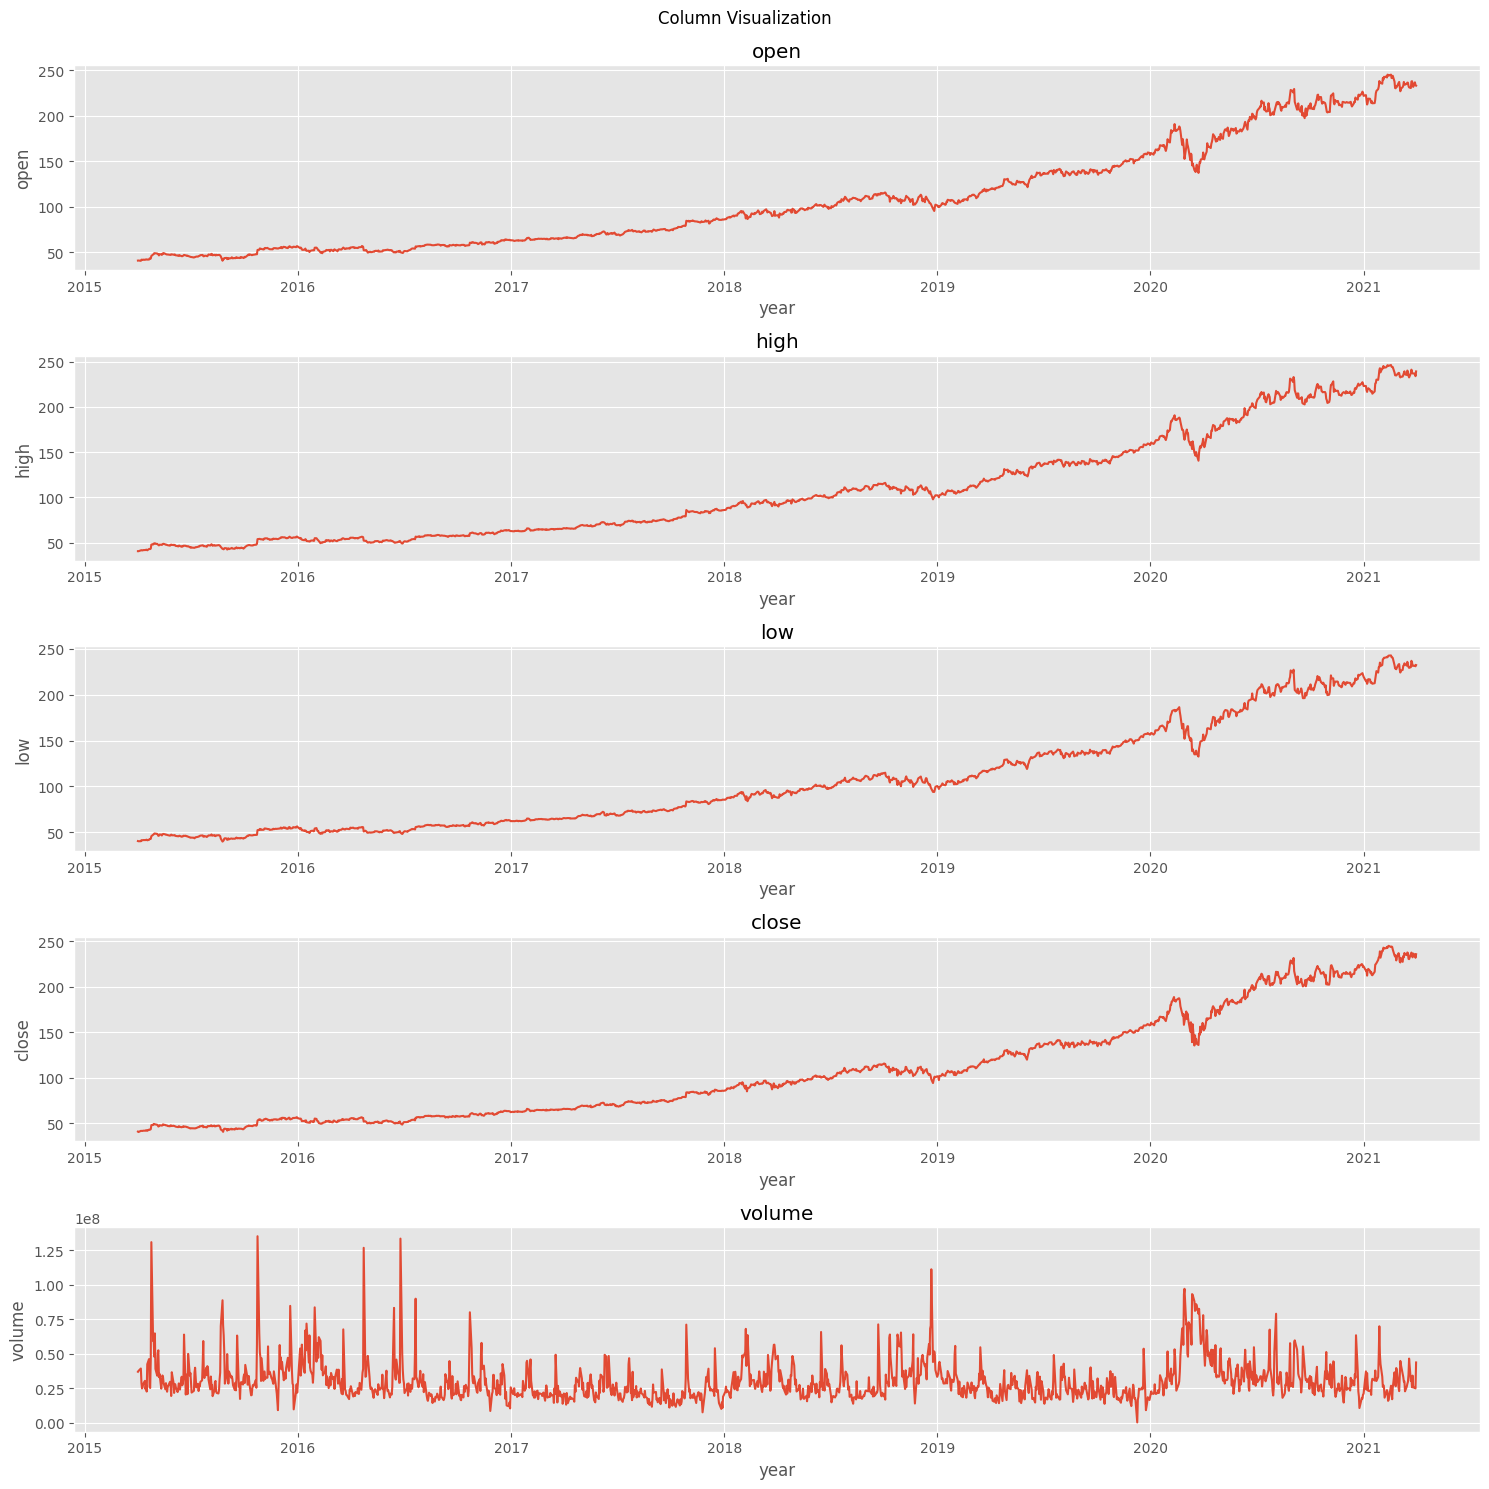

In [ ]:
plt.figure(figsize=(15, 15))
for idx, i in enumerate(df.columns, start=1):
    plt.subplot(5, 1, idx)
    plt.plot(df[i])
    plt.title(i)
    plt.ylabel(i)
    plt.xlabel("year")

plt.suptitle("Column Visualization", y=0.99)
plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

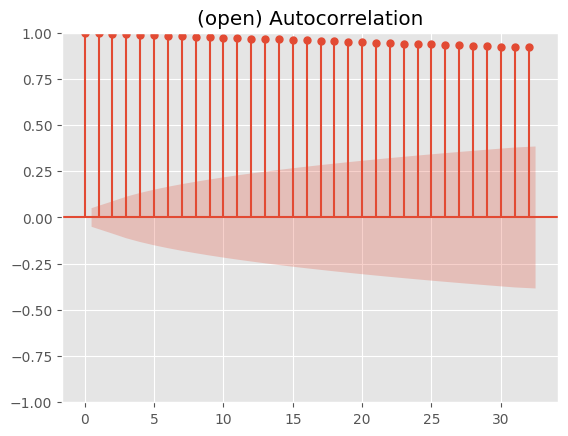

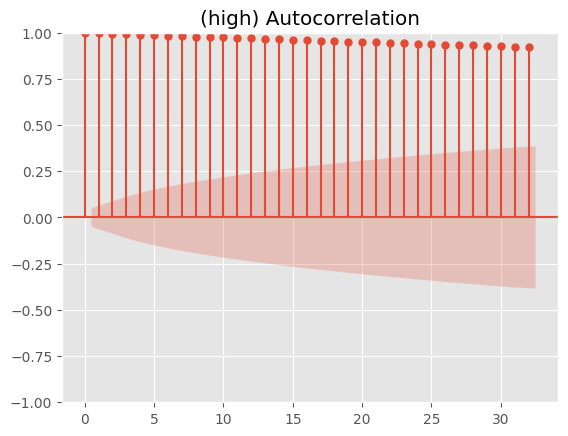

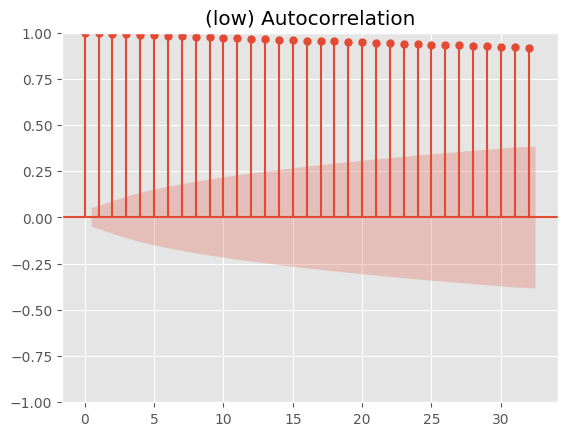

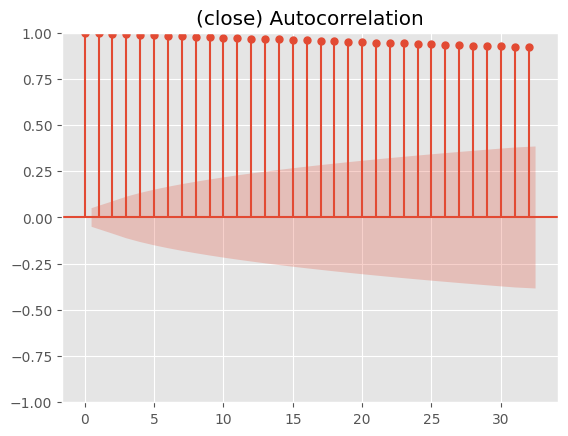

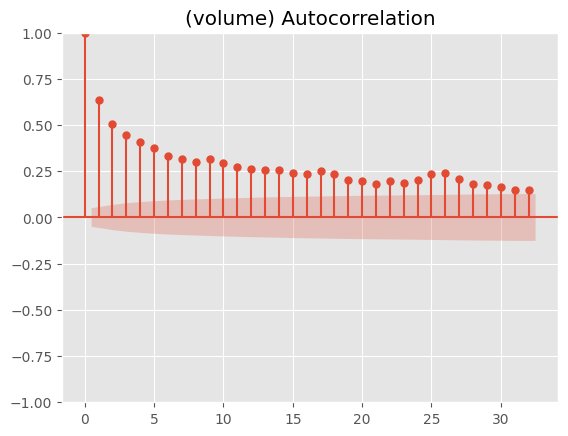

In [ ]:
plt.figure(figsize=(15, 15))
for idx, i in enumerate(df.columns, start=1):
    plot_acf(df[i], title=f"({i}) Autocorrelation")
plt.show()

<Figure size 1500x1500 with 0 Axes>

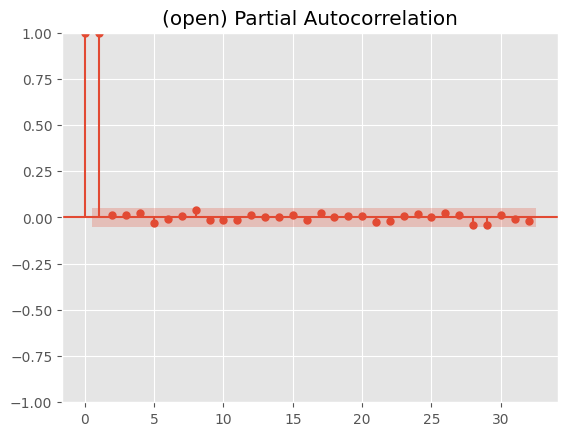

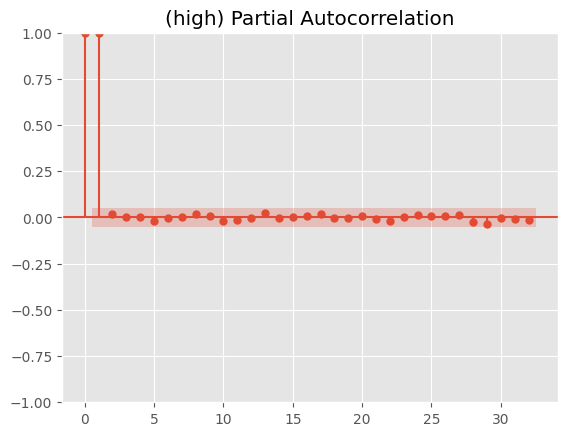

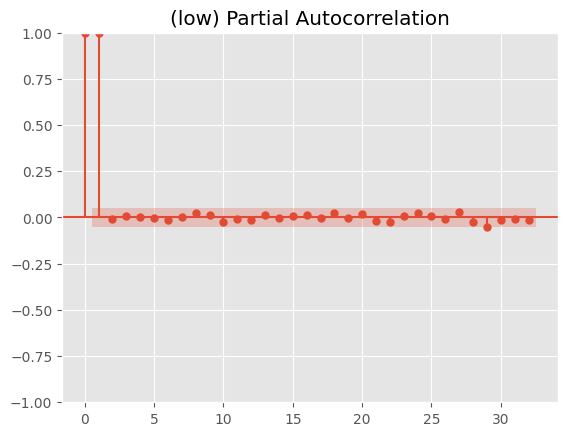

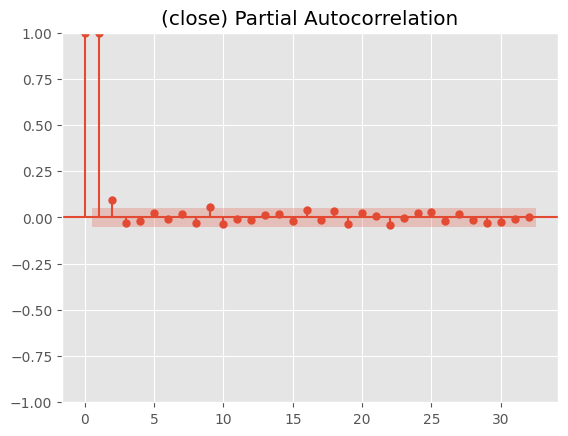

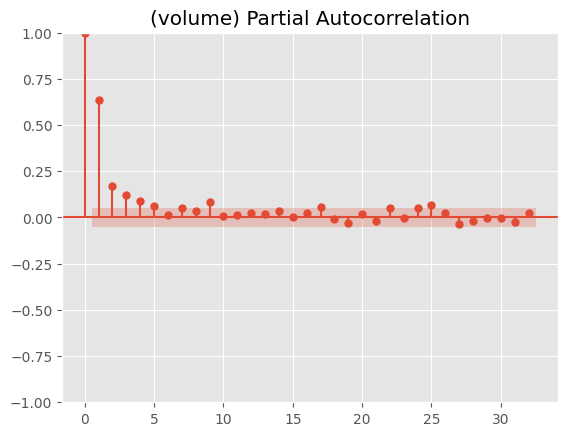

In [ ]:
plt.figure(figsize=(15, 15))
for idx, i in enumerate(df.columns, start=1):
    plot_pacf(df[i], title=f"({i}) Partial Autocorrelation")
plt.show()

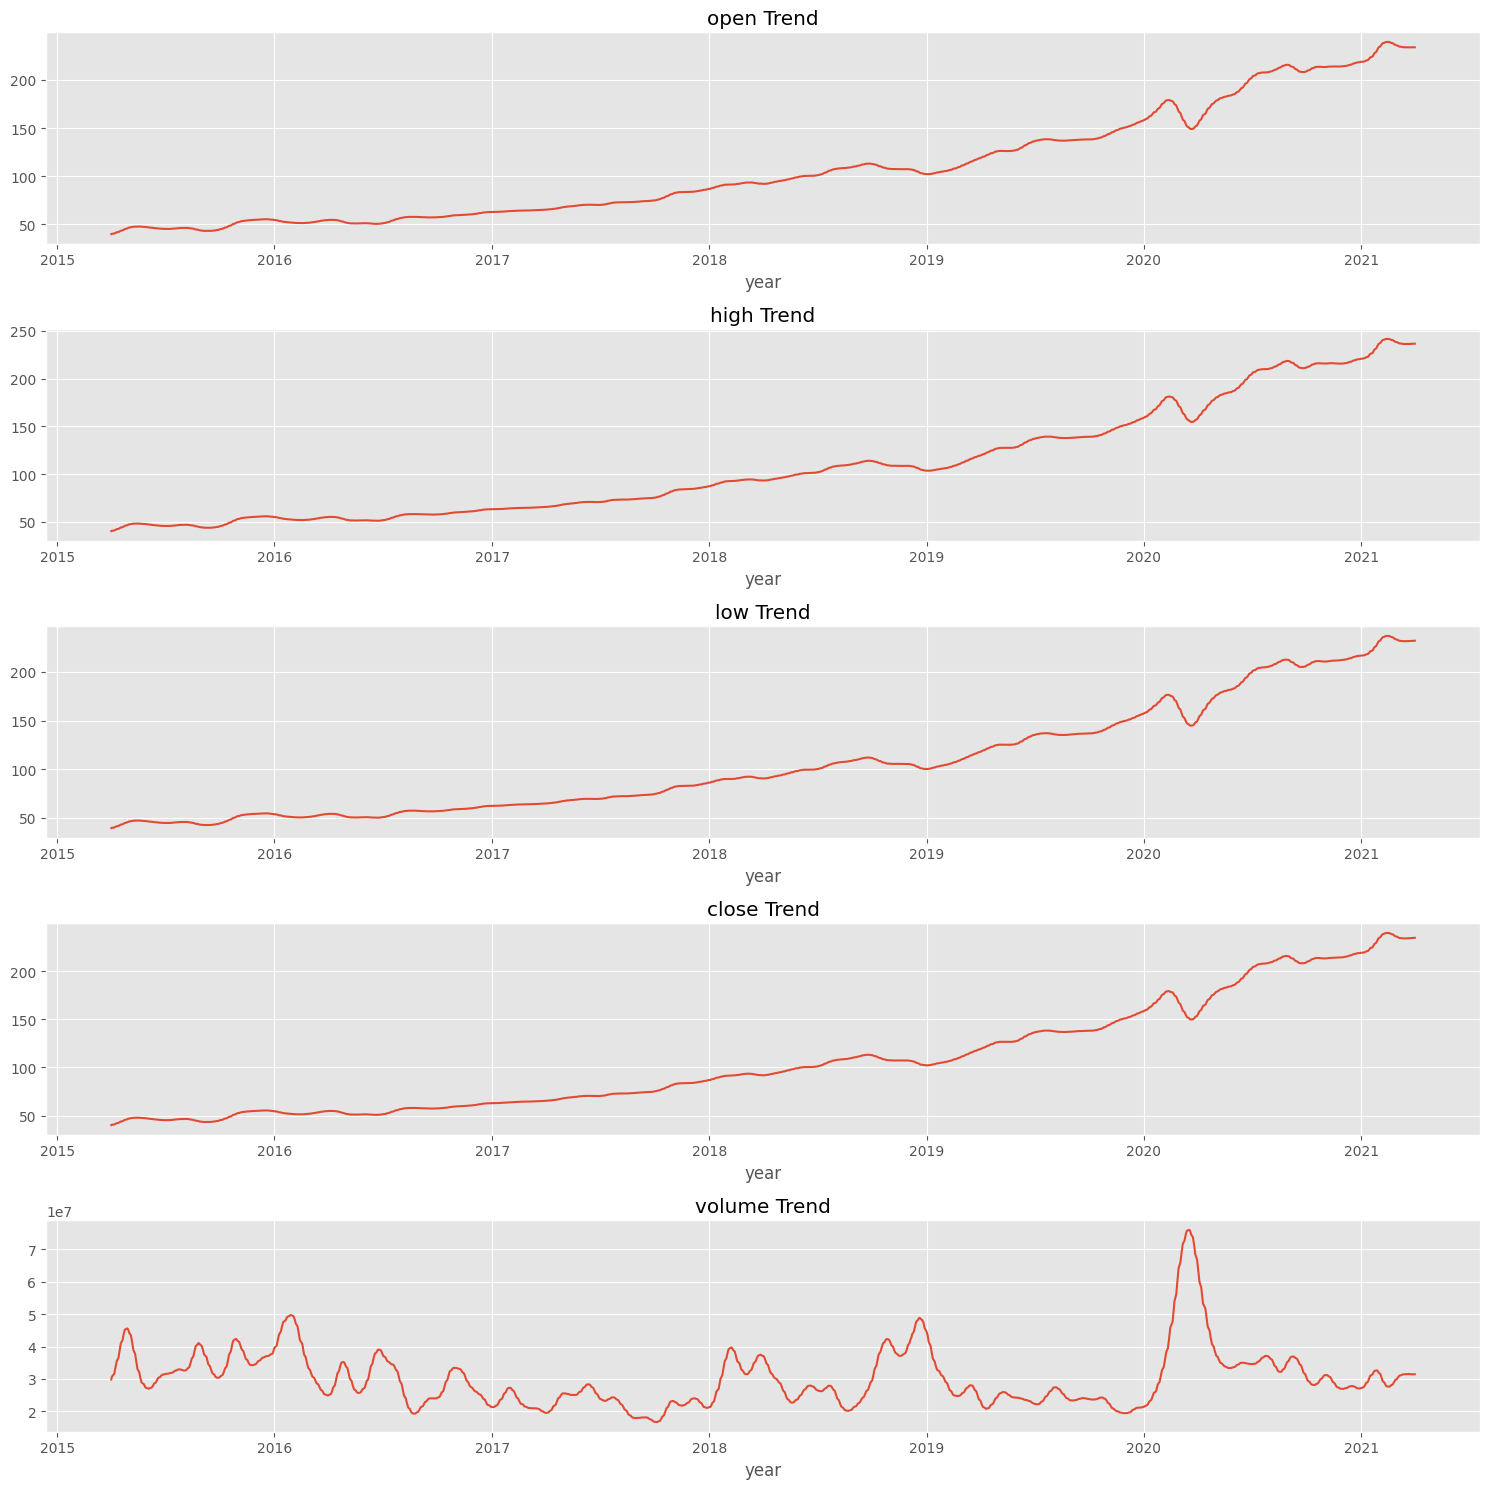

In [ ]:
def DetectTrend(df):
    plt.figure(figsize=(15, 15))
    for idx, i in enumerate(df.columns, start=1):
        cycle, trend = hpfilter(df[i])
        plt.subplot(5, 1, idx)
        plt.plot(trend)
        plt.xlabel("year")
        plt.title(f"{i} Trend")
    plt.tight_layout()
    plt.show()

DetectTrend(df)

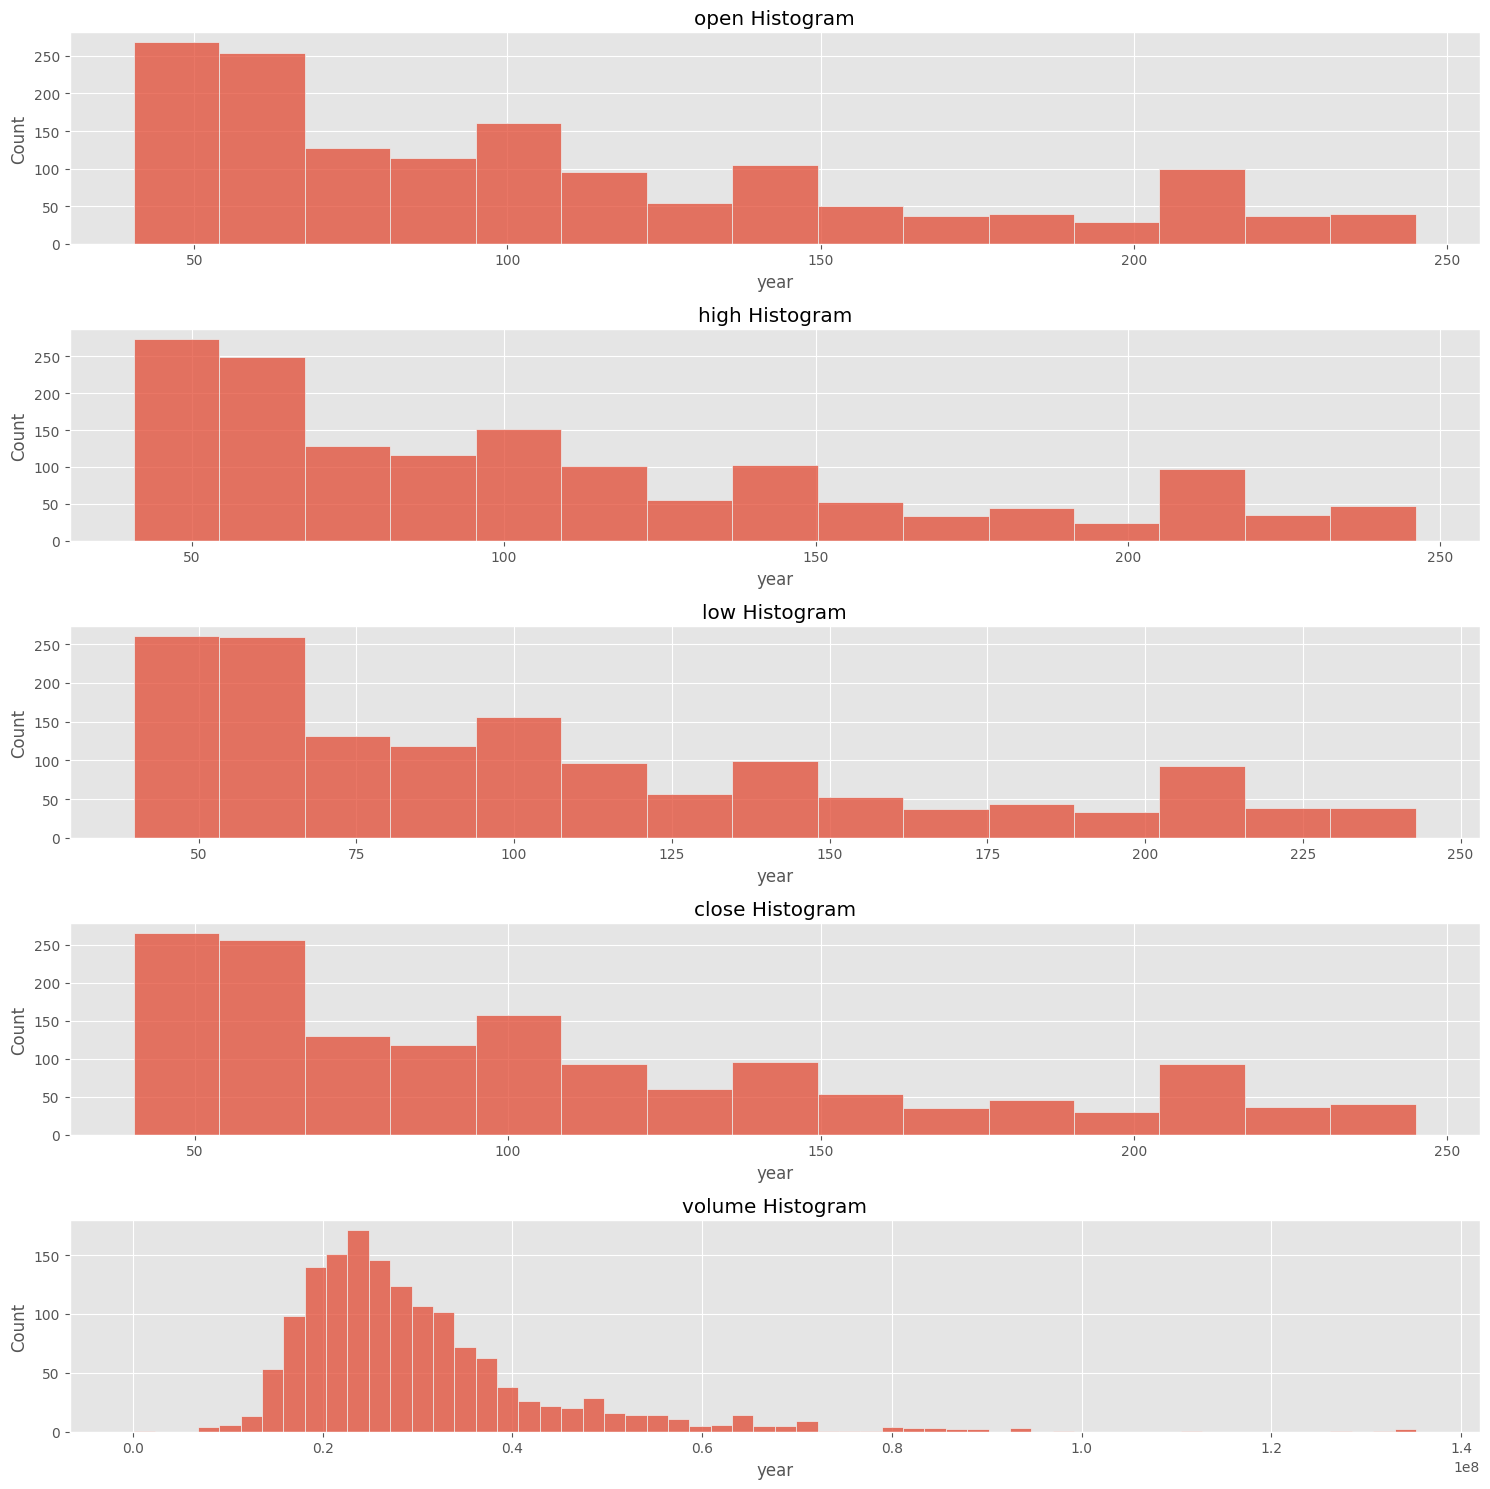

In [ ]:
plt.figure(figsize=(15, 15))
for idx, i in enumerate(df.columns, start=1):
    plt.subplot(5, 1, idx)
    sns.histplot(df[i])
    plt.xlabel("year")
    plt.title(f"{i} Histogram")

plt.tight_layout()
plt.show()

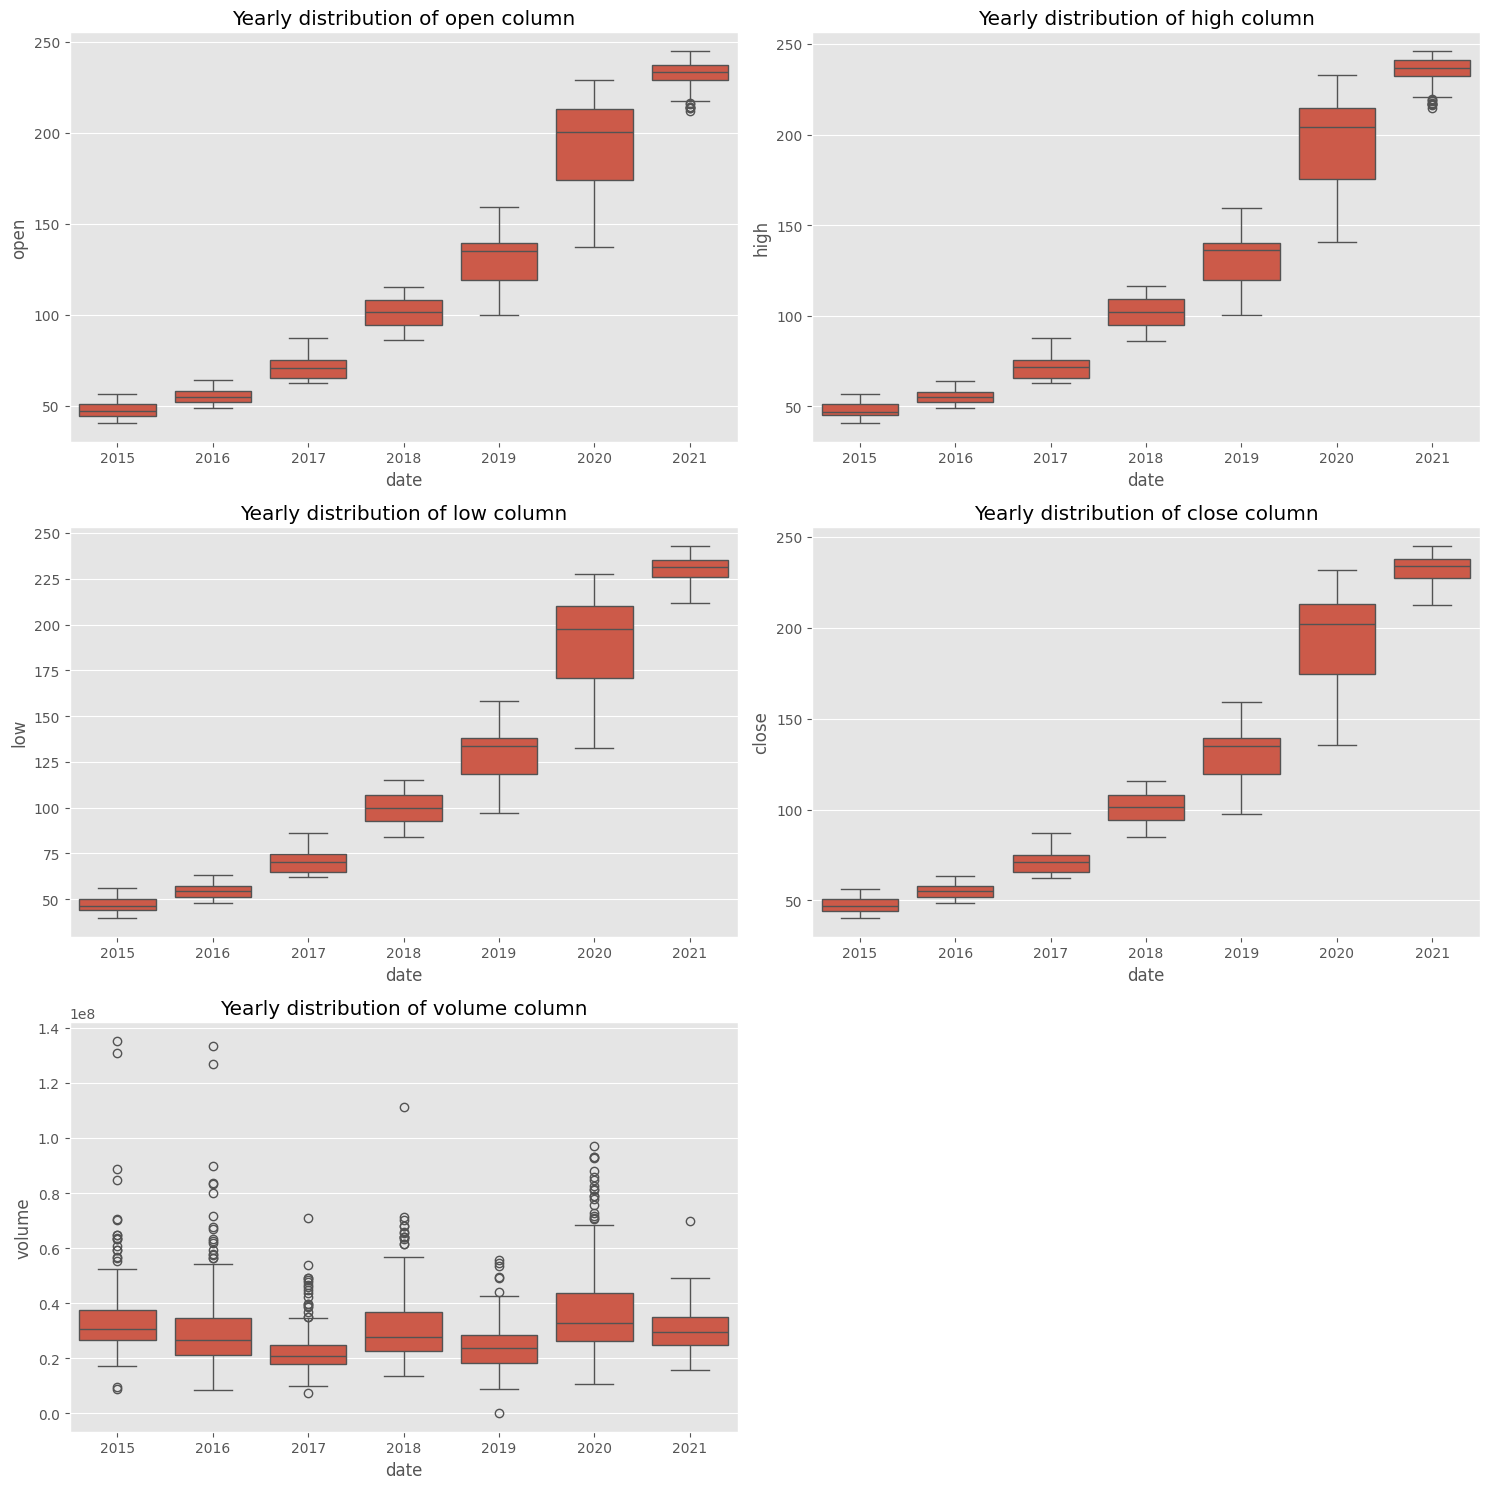

In [ ]:
plt.figure(figsize=(15, 15))
for idx, col in enumerate(df.columns, start=1):
    plt.subplot(3, 2, idx)
    sns.boxplot(x=df.index.year, y=df[col])
    plt.title(f"Yearly distribution of {col} column")

plt.tight_layout()
plt.show()

In [ ]:
def CheckDataStationarityStatus(df):
    for col in df.columns:
        result = pd.Series(adfuller(x=df[col])[0:4],
                           index=["Test Statistic", "p-value","No. Lags Used","No. of Observations Used"])
        print(f"---------{col}---------")
        print(result)
        if result[1] < 0.05:
            print("Status: Stationary", end="\n\n")
        else:
            print("Status: Non-Stationary", end="\n\n")

In [ ]:
CheckDataStationarityStatus(df)

---------open---------
Test Statistic                 0.823915
p-value                        0.992013
No. Lags Used                  2.000000
No. of Observations Used    1508.000000
dtype: float64
Status: Non-Stationary

---------high---------
Test Statistic                 1.570419
p-value                        0.997766
No. Lags Used                 14.000000
No. of Observations Used    1496.000000
dtype: float64
Status: Non-Stationary

---------low---------
Test Statistic                 1.224828
p-value                        0.996153
No. Lags Used                 14.000000
No. of Observations Used    1496.000000
dtype: float64
Status: Non-Stationary

---------close---------
Test Statistic                 1.737136
p-value                        0.998216
No. Lags Used                 24.000000
No. of Observations Used    1486.000000
dtype: float64
Status: Non-Stationary

---------volume---------
Test Statistic             -6.899656e+00
p-value                     1.291812e-09
No. L

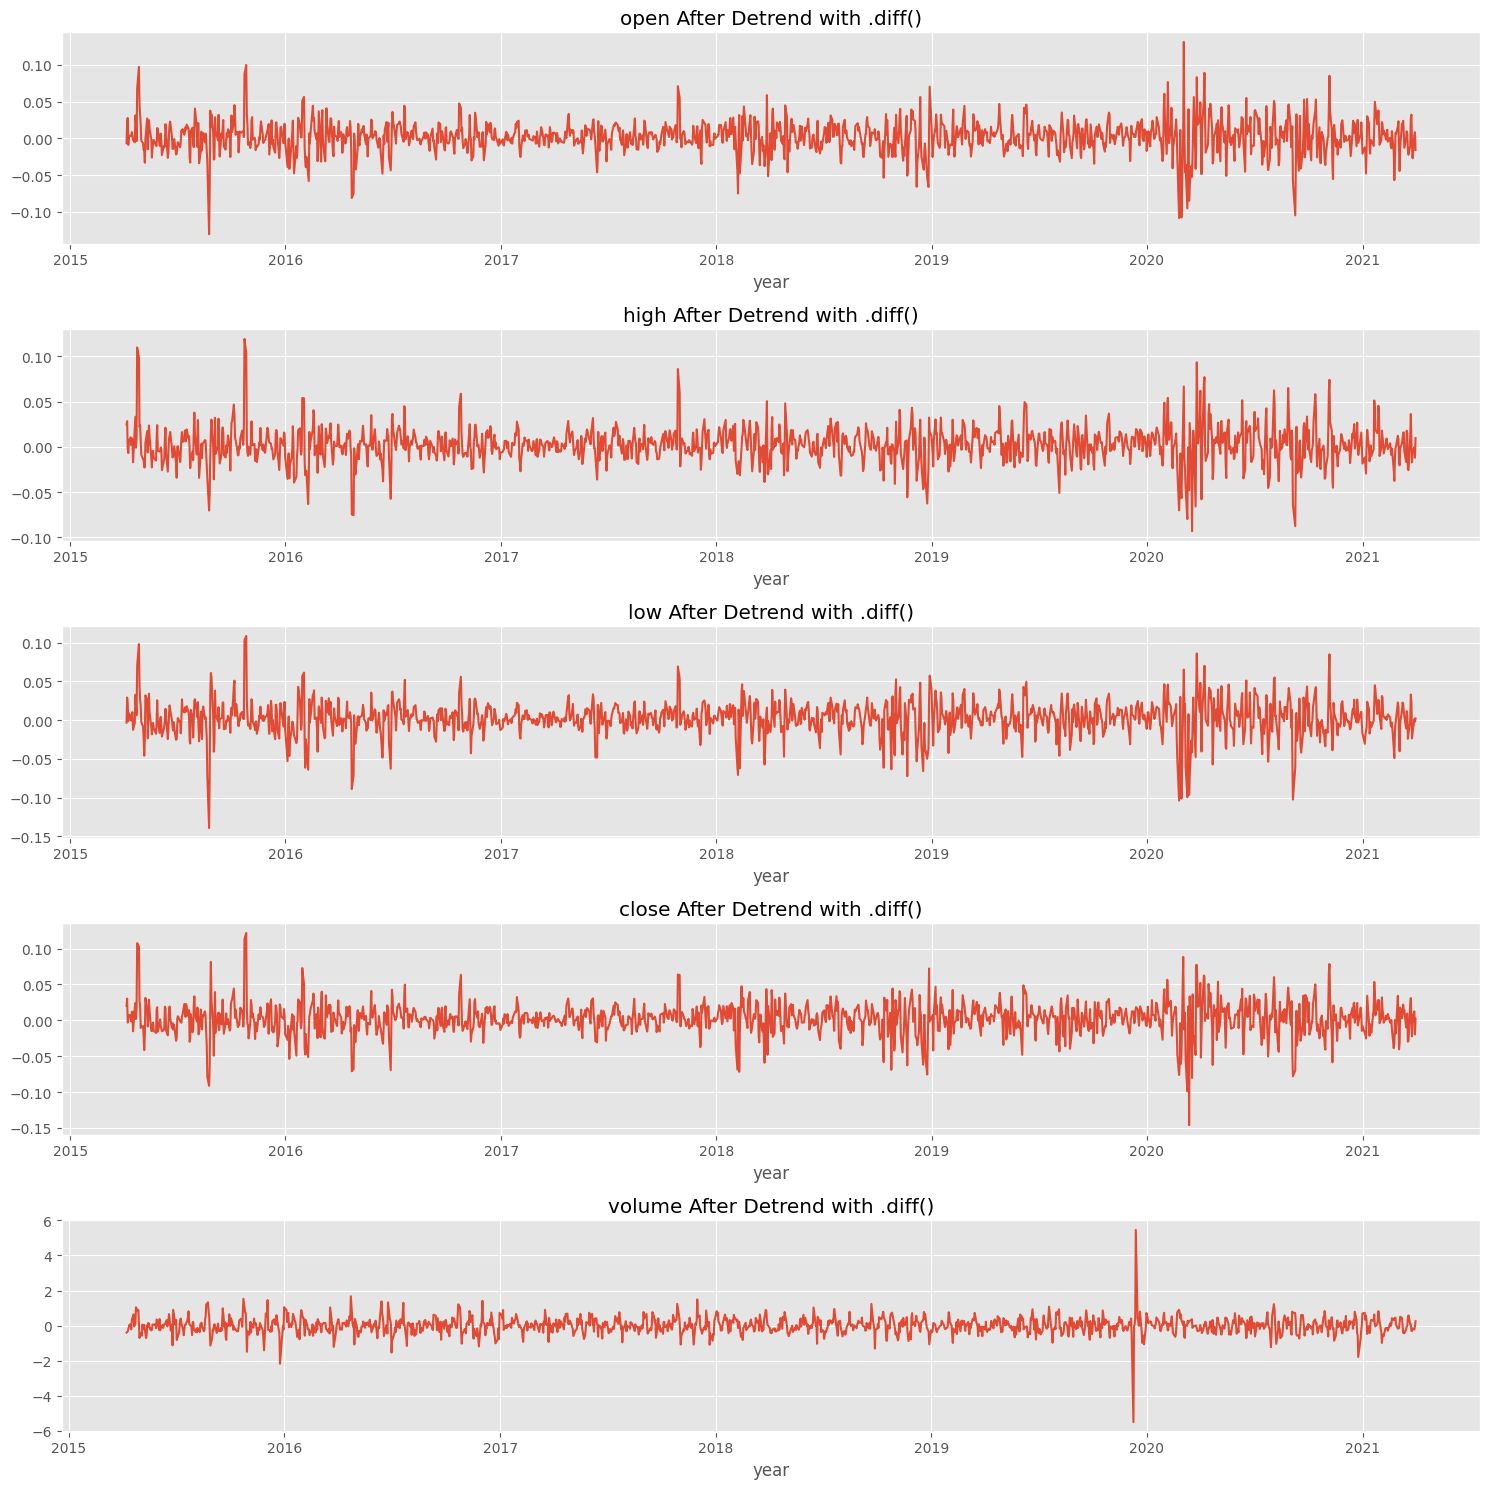

In [9]:
def DetectTrend(df_):
    df = df_.copy()
    plt.figure(figsize=(15, 15))
    for idx, i in enumerate(df.columns, start=1):
        plt.subplot(5, 1, idx)
        if i == "volume":
            plt.plot(np.log(df[i]).diff(4))
            df[f"stationary_{i}"] = np.log(df[i]).diff(4)
            plt.xlabel("year")
            plt.title(f"{i} After Detrend with .diff()")
        else:
            plt.plot(np.log(df[i]).diff(2))
            df[f"stationary_{i}"] = np.log(df[i]).diff(2)
            plt.xlabel("year")
            plt.title(f"{i} After Detrend with .diff()")
    plt.tight_layout()
    plt.show()

    return df

prep_df = DetectTrend(df)

In [ ]:
CheckDataStationarityStatus(prep_df.dropna())

---------open---------
Test Statistic                 0.836058
p-value                        0.992196
No. Lags Used                  2.000000
No. of Observations Used    1504.000000
dtype: float64
Status: Non-Stationary

---------high---------
Test Statistic                 1.677348
p-value                        0.998072
No. Lags Used                 14.000000
No. of Observations Used    1492.000000
dtype: float64
Status: Non-Stationary

---------low---------
Test Statistic                 1.304830
p-value                        0.996636
No. Lags Used                 14.000000
No. of Observations Used    1492.000000
dtype: float64
Status: Non-Stationary

---------close---------
Test Statistic                 1.745289
p-value                        0.998234
No. Lags Used                 24.000000
No. of Observations Used    1482.000000
dtype: float64
Status: Non-Stationary

---------volume---------
Test Statistic             -6.890405e+00
p-value                     1.360278e-09
No. L

In [ ]:
prep_df.describe()

,open,high,low,close,volume,stationary_open,stationary_high,stationary_low,stationary_close,stationary_volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1509.000000,1509.000000,1509.000000,1509.000000,1507.000000
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07,0.002316,0.002330,0.002321,0.002323,-0.000537
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07,0.021613,0.019364,0.021669,0.021696,0.459034
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05,-0.130095,-0.093212,-0.139368,-0.146002,-5.513126
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07,-0.008135,-0.007430,-0.007402,-0.008211,-0.242802
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07,0.002540,0.002394,0.002602,0.002986,-0.011794
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07,0.014078,0.012168,0.013250,0.013795,0.238779
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08,0.131331,0.119287,0.108753,0.121777,5.458380


In [ ]:
prep_df

,open,high,low,close,volume,stationary_open,stationary_high,stationary_low,stationary_close,stationary_volume
date,,,,,,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322,NaN,NaN,NaN,NaN,NaN
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476,NaN,NaN,NaN,NaN,NaN
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692,-0.006425,0.024717,-0.003230,0.020178,NaN
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375,0.023096,0.028314,0.029230,0.030313,NaN
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438,0.027868,-0.002156,0.021178,-0.003134,-0.398307
...,...,...,...,...,...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853,-0.009264,-0.017197,-0.023473,-0.022303,-0.309783
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853,-0.026844,-0.005435,-0.016150,0.004323,-0.167534
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455,0.005467,-0.000591,0.001338,0.012404,-0.226438


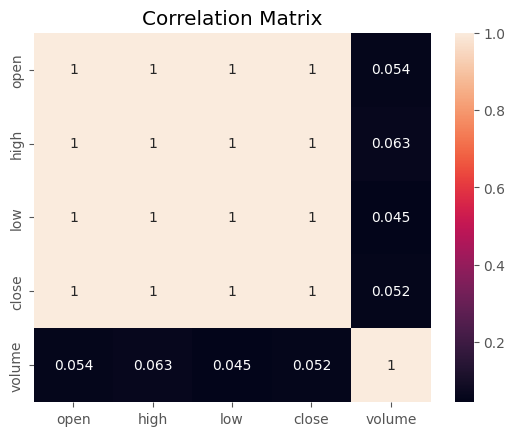

In [ ]:
sns.heatmap(prep_df[prep_df.columns[:5]].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
train_df = prep_df["open"][:-31]
test_df = prep_df["open"][-31:]

print(train_df.shape, test_df.shape)

(1480,) (31,)


In [ ]:
train_df

date
2015-04-01 16:00:00     40.60
2015-04-02 16:00:00     40.66
2015-04-06 16:00:00     40.34
2015-04-07 16:00:00     41.61
2015-04-08 16:00:00     41.48
                        ...  
2021-02-09 16:00:00    241.87
2021-02-10 16:00:00    245.00
2021-02-11 16:00:00    244.78
2021-02-12 16:00:00    243.93
2021-02-16 16:00:00    245.03
Name: open, Length: 1480, dtype: float64

In [ ]:
scaler = StandardScaler()

scaled_train = scaler.fit_transform(train_df.values.reshape(-1, 1))
scaled_test = scaler.fit_transform(test_df.values.reshape(-1, 1))

In [ ]:
scaled_train

array([[-1.18390554],
       [-1.1827978 ],
       [-1.18870573],
       ...,
       [ 2.58572234],
       [ 2.5700294 ],
       [ 2.59033791]])

In [ ]:
n_input=31

In [ ]:
series_generator_train = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=n_input, batch_size=1)

In [ ]:
batch_x, batch_y = series_generator_train[0]

print(batch_x.shape, batch_y.shape)

(1, 31, 1) (1, 1)


In [ ]:
print("X:", batch_x, "\ny:",batch_y)

X: [[[-1.18390554]
  [-1.1827978 ]
  [-1.18870573]
  [-1.16525864]
  [-1.16765873]
  [-1.17190506]
  [-1.16488939]
  [-1.16913571]
  [-1.1617508 ]
  [-1.16248929]
  [-1.15898146]
  [-1.1641509 ]
  [-1.16304316]
  [-1.13959607]
  [-1.14568862]
  [-1.14236541]
  [-1.09048641]
  [-1.06150064]
  [-1.05134638]
  [-1.03399184]
  [-1.03436109]
  [-1.03657656]
  [-1.04045364]
  [-1.05060789]
  [-1.05522346]
  [-1.07922442]
  [-1.05559271]
  [-1.05559271]
  [-1.0685163 ]
  [-1.04377685]
  [-1.04673081]]] 
y: [[-1.0312225]]


In [ ]:
input_layer = Input(shape=(n_input, 1))

x = layers.LSTM(units=128, activation='relu', return_sequences=True)(input_layer)
x = layers.LSTM(units=64, activation='relu')(x)
x = layers.Dense(units=64, activation='linear')(x)

output_layer = layers.Dense(units=1, activation='linear')(x)

time_series_model = Model(inputs=input_layer, outputs=output_layer)

time_series_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 31, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 120193 (469.50 KB)
Trainable params: 120193 (469.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf

def rmse(y_true, y_pred):
    loss = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    return loss

In [ ]:
time_series_model.compile(optimizer=optimizers.Adam(), loss=[rmse])

In [ ]:
model_history = time_series_model.fit(series_generator_train,
                                      batch_size=32,
                                      epochs=5,
                                      callbacks=[callbacks.EarlyStopping(patience=2, monitor="loss"),

                                                 callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=2, monitor="loss")])

Epoch 1/5
1449/1449 [==============================] - 128s 82ms/step - loss: 0.1041 - lr: 0.0010
Epoch 2/5
1449/1449 [==============================] - 121s 83ms/step - loss: 0.0770 - lr: 0.0010
Epoch 3/5
1449/1449 [==============================] - 117s 81ms/step - loss: 0.0671 - lr: 0.0010
Epoch 4/5
1449/1449 [==============================] - 115s 80ms/step - loss: 0.0586 - lr: 0.0010
Epoch 5/5
1449/1449 [==============================] - 118s 82ms/step - loss: 0.0576 - lr: 0.0010


In [ ]:
time_series_model.predict(scaled_test.reshape(1, n_input, 1))

1/1 [==============================] - 0s 444ms/step


array([[-0.22878551]], dtype=float32)

In [ ]:
open_pred = []
current_test_batch = scaled_test.reshape((1, n_input, 1))

print(current_test_batch.shape)

for i in range(len(test_df)):
    model_pred = time_series_model.predict(current_test_batch)[0]
    open_pred.append(model_pred)
    current_test_batch = np.append(current_test_batch[:, 1:, :], [[model_pred]], axis=1)

(1, 31, 1)
1/1 [==============================] - 0s 25ms/step


In [ ]:
open_pred

[array([-0.22878551], dtype=float32),
 array([-0.2652832], dtype=float32),
 array([-0.2903399], dtype=float32),
 array([-0.30959746], dtype=float32),
 array([-0.32598034], dtype=float32),
 array([-0.3400735], dtype=float32),
 array([-0.3527991], dtype=float32),
 array([-0.3643622], dtype=float32),
 array([-0.37509337], dtype=float32),
 array([-0.38529477], dtype=float32),
 array([-0.39512482], dtype=float32),
 array([-0.40470597], dtype=float32),
 array([-0.4140297], dtype=float32),
 array([-0.42312944], dtype=float32),
 array([-0.43201545], dtype=float32),
 array([-0.44069842], dtype=float32),
 array([-0.4491752], dtype=float32),
 array([-0.45747295], dtype=float32),
 array([-0.46560594], dtype=float32),
 array([-0.47358695], dtype=float32),
 array([-0.48141757], dtype=float32),
 array([-0.48909047], dtype=float32),
 array([-0.496604], dtype=float32),
 array([-0.5039596], dtype=float32),
 array([-0.51119345], dtype=float32),
 array([-0.5182237], dtype=float32),
 array([-0.5251258], dt

In [ ]:
open_prediction = scaler.inverse_transform(open_pred)

In [ ]:
test_df = pd.DataFrame(test_df)

test_df["open-pred"] = np.round(open_prediction, 2)

test_df

,open,open-pred
date,,
2021-02-17 16:00:00,241.32,233.53
2021-02-18 16:00:00,241.80,233.39
2021-02-19 16:00:00,243.75,233.30
2021-02-22 16:00:00,237.42,233.23
2021-02-23 16:00:00,230.33,233.17
2021-02-24 16:00:00,230.01,233.11
2021-02-25 16:00:00,232.08,233.06
2021-02-26 16:00:00,231.53,233.02
2021-03-01 16:00:00,235.90,232.98


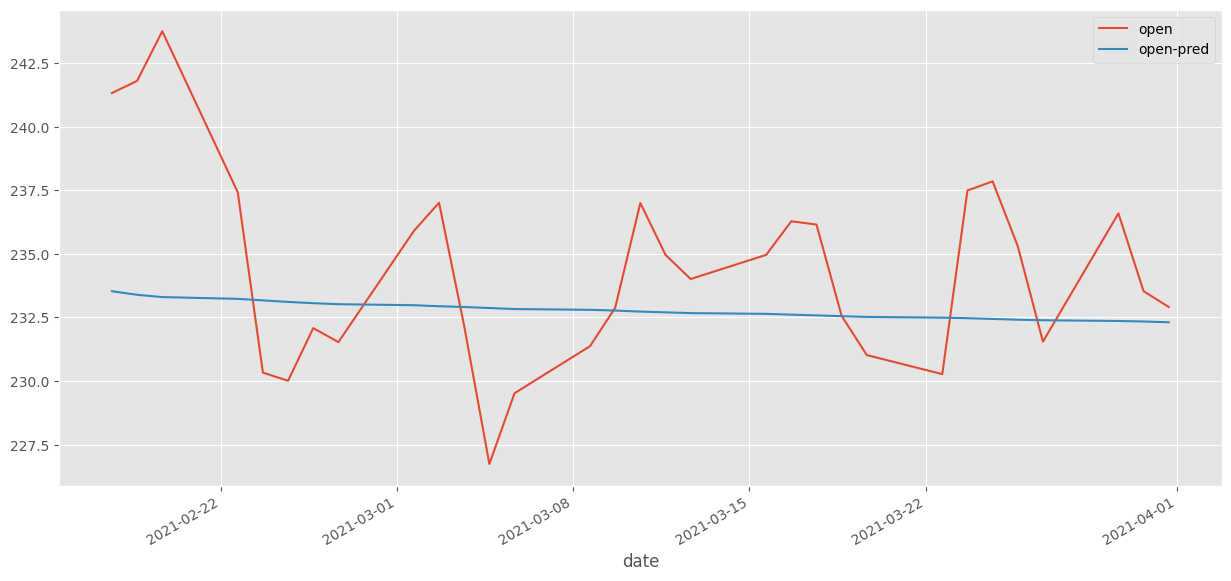

In [ ]:
test_df.plot(figsize=(15, 7), title="LSTM prediction vs Actual Prediction")
plt.show()

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units=hp.Int('lstm_1', min_value=32, max_value=1000, step=32), input_shape=(31,1), activation=hp.Choice('activation_1', values=['relu', 'tanh']), return_sequences=True))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.LSTM(units=hp.Int('units_2', min_value=32, max_value=1000, step=32), activation=hp.Choice('activation_2', values=['relu', 'tanh'])))
    model.add(layers.Dense(units=1))
    model.compile(loss=[rmse], optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']))
    return model

model_tuner = RandomSearch(build_model,
                           objective='loss',
                           max_trials=10,
                           executions_per_trial=1)


In [ ]:
model_tuner.search(series_generator_train,
                   epochs=5,
                   batch_size=32,
                   callbacks=[callbacks.EarlyStopping(patience=10, monitor="loss")])

Trial 10 Complete [00h 01m 50s]
loss: 0.11677653342485428

Best loss So Far: 0.05983458086848259
Total elapsed time: 01h 01m 56s


In [ ]:
best_model = model_tuner.get_best_models(num_models=1)[0]

open_pred = []
current_test_batch = scaled_test.reshape((1, n_input, 1))

print(current_test_batch.shape)

for i in range(len(test_df)):
    model_pred = best_model.predict(current_test_batch)[0]
    open_pred.append(model_pred)
    current_test_batch = np.append(current_test_batch[:, 1:, :], [[model_pred]], axis=1)

(1, 31, 1)
1/1 [==============================] - 0s 18ms/step


In [ ]:
open_prediction = scaler.inverse_transform(open_pred)

test_df["open-pred-optimized"] = np.round(open_prediction, 2)

test_df

,open,open-pred,open-pred-optimized
date,,,
2021-02-17 16:00:00,241.32,233.53,234.33
2021-02-18 16:00:00,241.80,233.39,234.20
2021-02-19 16:00:00,243.75,233.30,234.12
2021-02-22 16:00:00,237.42,233.23,234.07
2021-02-23 16:00:00,230.33,233.17,234.04
2021-02-24 16:00:00,230.01,233.11,234.01
2021-02-25 16:00:00,232.08,233.06,233.98
2021-02-26 16:00:00,231.53,233.02,233.95
2021-03-01 16:00:00,235.90,232.98,233.93


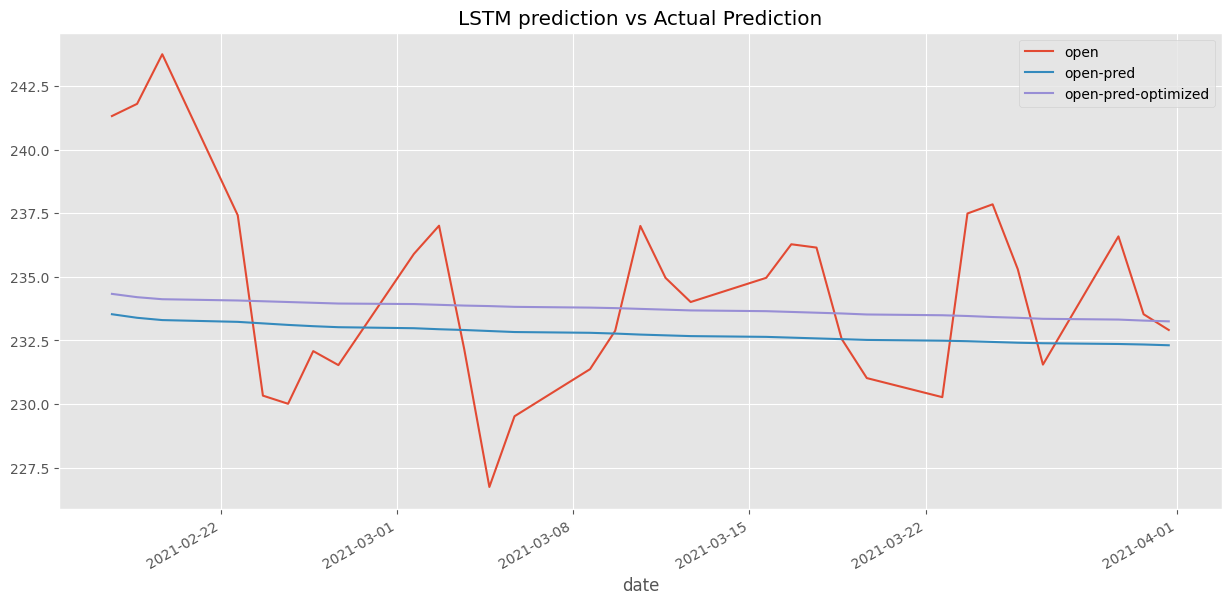

In [ ]:
test_df.plot(figsize=(15, 7), title="LSTM prediction vs Actual Prediction")
plt.show()

In [ ]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
X, y = create_dataset(scaled_train, 31)

In [ ]:
input_layer = Input(shape=(n_input, 1))

x = layers.LSTM(units=128, activation='relu', return_sequences=True)(input_layer)
x = layers.LSTM(units=64, activation='relu')(x)
x = layers.Dense(units=64, activation='linear')(x)

output_layer = layers.Dense(units=1, activation='linear')(x)

time_series_model = Model(inputs=input_layer, outputs=output_layer)

time_series_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 31, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 120193 (469.50 KB)
Trainable params: 120193 (469.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
time_series_model.compile(optimizer=optimizers.Adam(), loss=[rmse])

In [ ]:
model_history = time_series_model.fit(X, y,
                                      validation_split=0.8,
                                      batch_size=32,
                                      epochs=5,
                                      callbacks=[callbacks.EarlyStopping(patience=2, monitor="loss"),

                                                 callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=2, monitor="loss")])

Epoch 1/5
10/10 [==============================] - 4s 392ms/step - loss: 0.0520 - val_loss: 0.1184 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 2s 256ms/step - loss: 0.0436 - val_loss: 0.1368 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 2s 254ms/step - loss: 0.0380 - val_loss: 0.1417 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 1s 143ms/step - loss: 0.0292 - val_loss: 0.1447 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - 1s 121ms/step - loss: 0.0373 - val_loss: 0.1473 - lr: 0.0010


In [ ]:
test_df["open-pred-method_2"] = np.round(scaler.inverse_transform(time_series_model.predict(scaled_test)), 2)

test_df

1/1 [==============================] - 0s 30ms/step


,open,open-pred,open-pred-optimized,open-pred-method_2
date,,,,
2021-02-17 16:00:00,241.32,233.53,234.33,234.470001
2021-02-18 16:00:00,241.80,233.39,234.20,234.490005
2021-02-19 16:00:00,243.75,233.30,234.12,234.559998
2021-02-22 16:00:00,237.42,233.23,234.07,234.300003
2021-02-23 16:00:00,230.33,233.17,234.04,233.960007
2021-02-24 16:00:00,230.01,233.11,234.01,233.949997
2021-02-25 16:00:00,232.08,233.06,233.98,234.029999
2021-02-26 16:00:00,231.53,233.02,233.95,234.009995
2021-03-01 16:00:00,235.90,232.98,233.93,234.229996


<Axes: xlabel='date'>

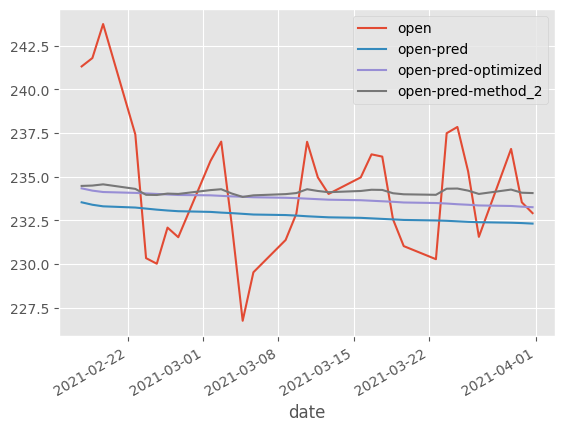

In [ ]:
# Model used is LSTM
test_df.plot()

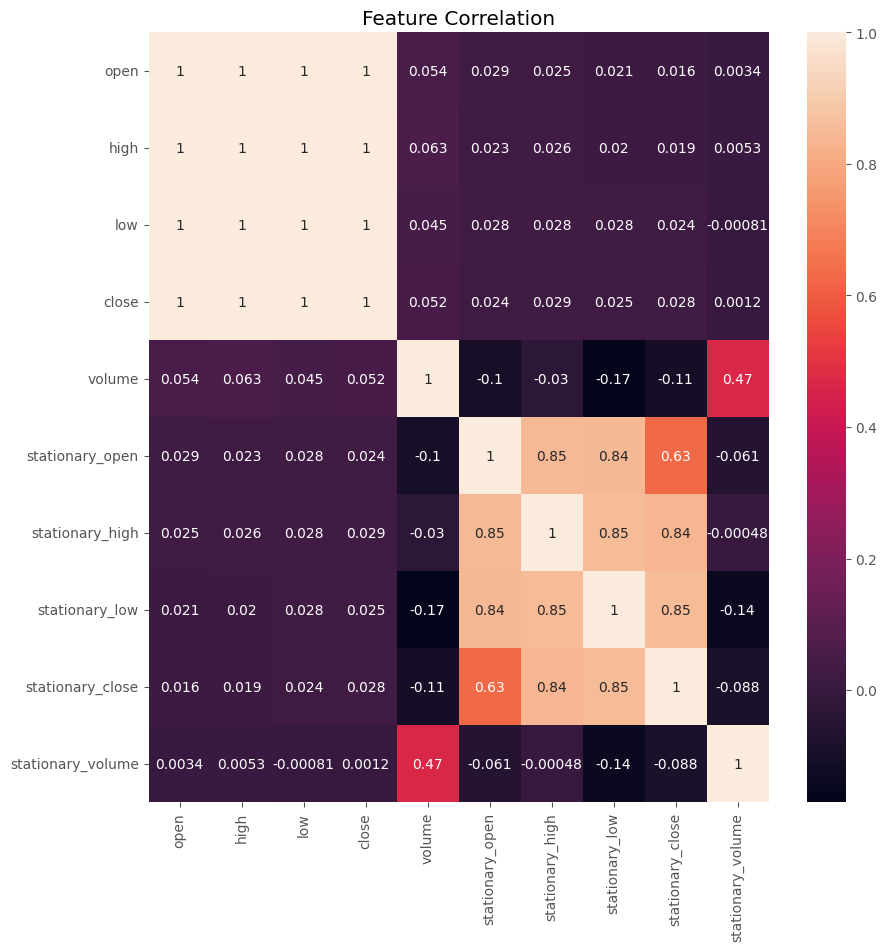

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(prep_df.corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

In [21]:
df["open_lag_1"] = df["open"].shift(1)
df["open_lag_2"] = df["open"].shift(2)
df["open_lag_3"] = df["open"].shift(3)

In [24]:
train_df = df[["open", "open_lag_1", "open_lag_2", "open_lag_3"]]

In [25]:
Xtrain = train_df[:-31]
Xtest = train_df[-31:]

In [27]:
X = Xtrain[["open_lag_1", "open_lag_2", "open_lag_3"]]
y = Xtrain["open"]

In [29]:
XTEST = Xtest[["open_lag_1", "open_lag_2", "open_lag_3"]]
YTEST = Xtest["open"]

In [88]:
def TrainModel(X, y, n_split):
    tsp = TimeSeriesSplit(n_splits=n_split, )

    model = XGBRegressor()

    rmse = []

    pred_per_fold = pd.DataFrame()

    for idx, (train_idx, test_idx) in enumerate(tsp.split(X, y), start=1):
        xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
        ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(xtrain, ytrain)

        pred = model.predict(xtest)

        rmse.append(np.sqrt(mean_squared_error(ytest, pred)))

        pred_per_fold[f"fold_{idx}"] = model.predict(XTEST)

    print(f"RMSE: {np.mean(rmse)}")

    return pred_per_fold

In [93]:
result = TrainModel(X, y, 600)

RMSE: 2.17012318803658


In [102]:
xgb_pred = pd.DataFrame(YTEST)

xgb_pred["time_series_split_pred"] = result.mean(axis=1).values

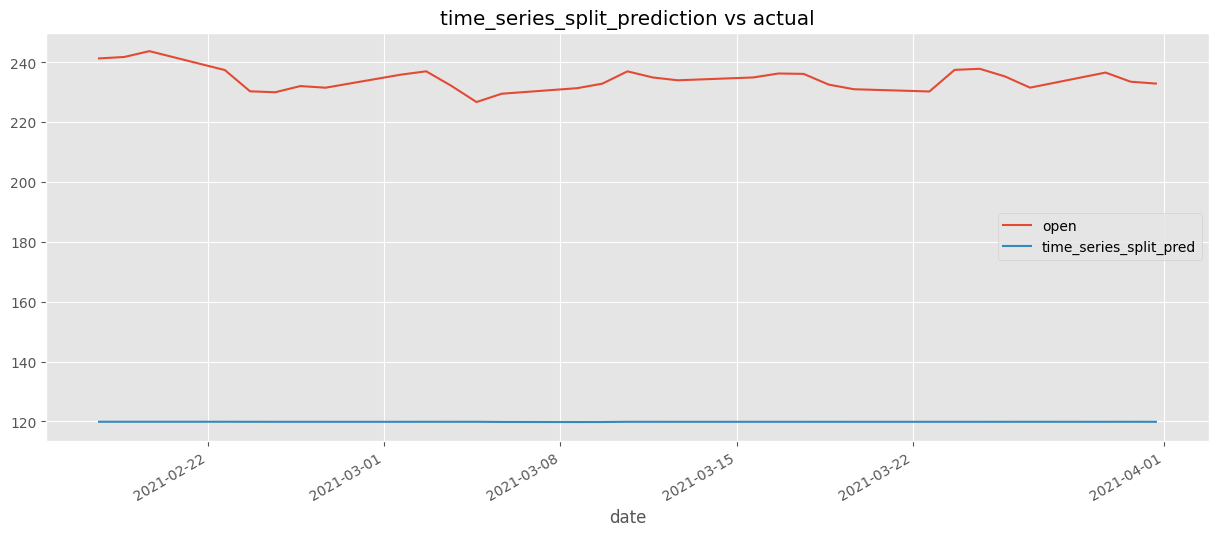

In [105]:
xgb_pred.plot(figsize=(15, 6), title="time_series_split_prediction vs actual")
plt.show()

In [106]:
model = XGBRegressor()

model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [107]:
xgb_pred["xgb_pred"] = model.predict(XTEST)

In [108]:
xgb_pred

,open,time_series_split_pred,xgb_pred
date,,,
2021-02-17 16:00:00,241.32,119.891678,243.983093
2021-02-18 16:00:00,241.80,119.891678,242.331451
2021-02-19 16:00:00,243.75,119.891678,242.331451
2021-02-22 16:00:00,237.42,119.891678,243.983093
2021-02-23 16:00:00,230.33,119.878349,242.331451
2021-02-24 16:00:00,230.01,119.874817,236.818665
2021-02-25 16:00:00,232.08,119.875015,236.818665
2021-02-26 16:00:00,231.53,119.873840,236.818665
2021-03-01 16:00:00,235.90,119.873840,236.818665


In [109]:
np.sqrt(mean_squared_error(xgb_pred["open"], xgb_pred["xgb_pred"]))

4.651535185234019

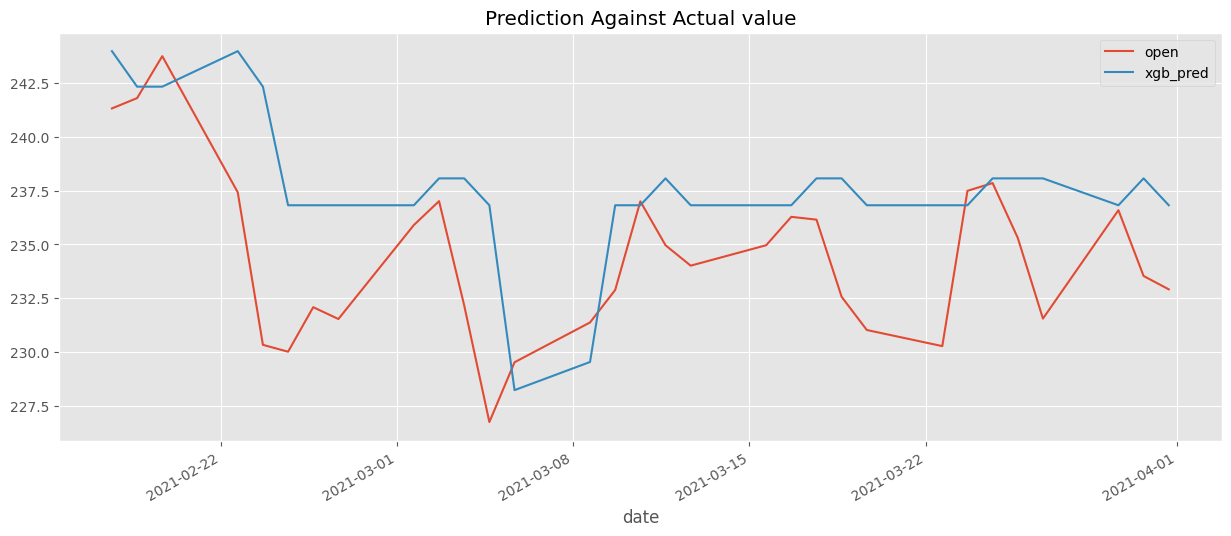

In [111]:
xgb_pred[["open", "xgb_pred"]].plot(figsize=(15, 6), title="Prediction Against Actual value")
plt.show()

In [165]:
def Objective(trial, X, y, xtest, ytest):
    param_ranges = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 0.2),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 1.0),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 3)
    }

    model = XGBRegressor(**param_ranges)

    model.fit(X, y)

    pred = model.predict(xtest)

    return np.sqrt(mean_squared_error(ytest, pred))

In [169]:
opt_func = partial(Objective, X=X, y=y, xtest=XTEST, ytest=YTEST)

In [170]:
study = create_study(direction="minimize")

[I 2024-05-06 21:51:15,534] A new study created in memory with name: no-name-d474ec5e-fbd4-4450-8af1-b42ac37efed0


In [173]:
study.optimize(opt_func, n_trials=100, show_progress_bar=True, )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-05-06 21:52:08,772] Trial 55 finished with value: 4.844974319513956 and parameters: {'learning_rate': 0.22186400412097862, 'n_estimators': 101, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6703556912131006, 'colsample_bytree': 0.9341860990445856, 'gamma': 0.16644716214745747, 'reg_alpha': 0.5398762423965376, 'reg_lambda': 0.15545131547078578, 'scale_pos_weight': 1}. Best is trial 30 with value: 3.8287074127393.
[I 2024-05-06 21:52:11,863] Trial 56 finished with value: 5.1980044449052105 and parameters: {'learning_rate': 0.27199077558210377, 'n_estimators': 172, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6874677124511165, 'colsample_bytree': 0.8772094771068678, 'gamma': 0.09776748356916946, 'reg_alpha': 0.3149332209444516, 'reg_lambda': 0.9237267095867162, 'scale_pos_weight': 1}. Best is trial 30 with value: 3.8287074127393.
[I 2024-05-06 21:52:13,908] Trial 57 finished with value: 4.9736845020879805 and parameters: {'learning_rate': 0.25569038060251587, 'n_e

In [177]:
model = XGBRegressor(**study.best_params)

model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9998326809930714, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.11972137290877854,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2928401324724621,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=115, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [178]:
xgb_pred["xgb_pred_tuned"] = model.predict(XTEST)

In [179]:
np.sqrt(mean_squared_error(xgb_pred["open"], xgb_pred["xgb_pred_tuned"]))

3.8213739843463657

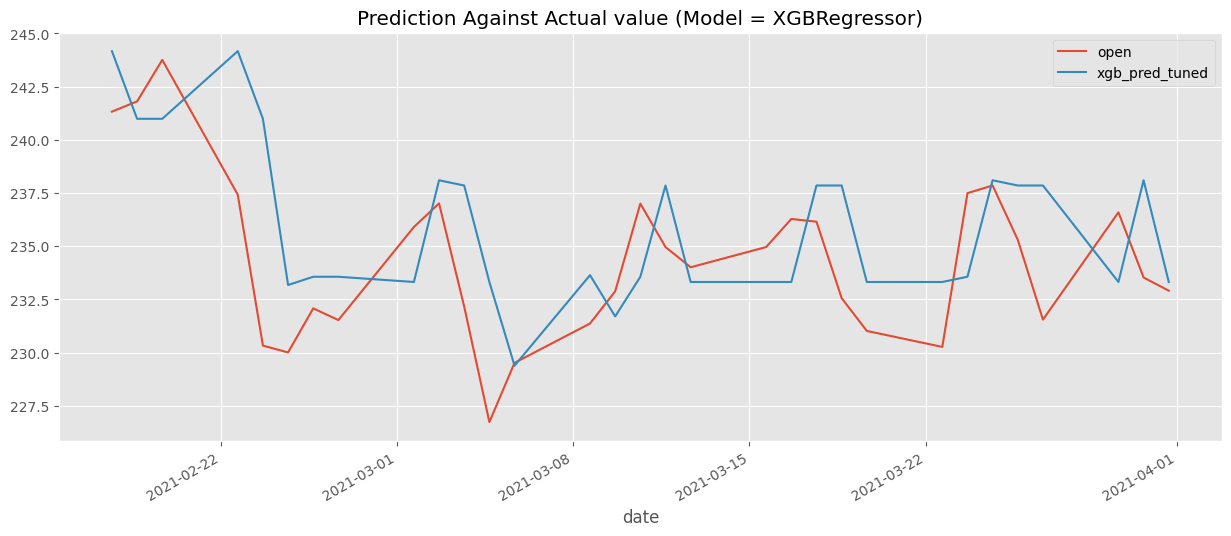

In [181]:
xgb_pred[["open", "xgb_pred_tuned"]].plot(figsize=(15, 6), title="Prediction Against Actual value (Model = XGBRegressor)")
plt.show()

In [185]:
!pip install catboost

In [186]:
from catboost import CatBoostRegressor

In [187]:
model = CatBoostRegressor()

model.fit(X, y)

Learning rate set to 0.043559
0:	learn: 51.9235467	total: 51.5ms	remaining: 51.4s
1:	learn: 49.7817210	total: 52.7ms	remaining: 26.3s
2:	learn: 47.7257556	total: 56.2ms	remaining: 18.7s
3:	learn: 45.7647289	total: 57.5ms	remaining: 14.3s
4:	learn: 43.8623516	total: 58.8ms	remaining: 11.7s
5:	learn: 42.0621598	total: 63.5ms	remaining: 10.5s
6:	learn: 40.3192066	total: 66.9ms	remaining: 9.48s
7:	learn: 38.6953228	total: 68ms	remaining: 8.43s
8:	learn: 37.1103327	total: 75.5ms	remaining: 8.32s
9:	learn: 35.6037306	total: 76.7ms	remaining: 7.59s
10:	learn: 34.1392805	total: 77.8ms	remaining: 6.99s
11:	learn: 32.7532561	total: 78.9ms	remaining: 6.5s
12:	learn: 31.4498420	total: 86.8ms	remaining: 6.59s
13:	learn: 30.1660515	total: 87.9ms	remaining: 6.19s
14:	learn: 28.9780615	total: 89ms	remaining: 5.85s
15:	learn: 27.7940354	total: 90.4ms	remaining: 5.56s
16:	learn: 26.6794549	total: 91.9ms	remaining: 5.32s
17:	learn: 25.5859666	total: 93.1ms	remaining: 5.08s
18:	learn: 24.5717398	total: 94

In [188]:
catboost_pred = pd.DataFrame(YTEST)

catboost_pred["catboost_forcast"] = model.predict(XTEST)

In [189]:
np.sqrt(mean_squared_error(catboost_pred["open"], catboost_pred["catboost_forcast"]))

5.836416080165971

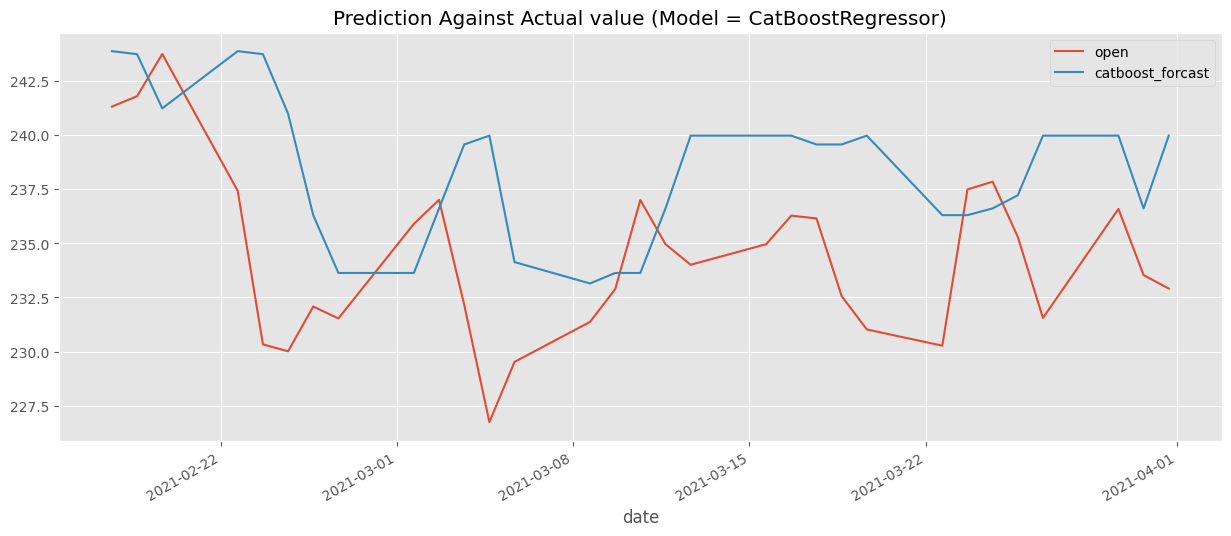

In [190]:
catboost_pred[["open", "catboost_forcast"]].plot(figsize=(15, 6), title="Prediction Against Actual value (Model = CatBoostRegressor)")
plt.show()